### Import necessary libraries

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import FunctionTransformer

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score

# Load the dataset

In [2]:
# Import data from CSV file
file_path = 'Data/day.csv'

try:
    dayData = pd.read_csv(file_path, delimiter=',', low_memory=False)
    print('Data Load: Successful')
except FileNotFoundError:
    print(f'Error: File "{file_path}" not found.')
except pd.errors.EmptyDataError:
    print(f'Error: File "{file_path}" is empty.')
except pd.errors.ParserError:
    print(f'Error: Unable to parse data from file "{file_path}". Check the file format.')
except Exception as e:
    import traceback
    traceback.print_exc()
    print(f'Error: An unexpected error occurred while loading data. {str(e)}')
    print('Data Load: Failure')


Data Load: Successful


# Data Understanding

In [3]:
# Print the head of the data
print("Head of the Data:")
dayData.head()     # Adjust the number as needed

Head of the Data:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# Print the tail of the data
print("\nTail of the Data:")
dayData.tail()     # Adjust the number as needed


Tail of the Data:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796
729,730,31-12-2019,1,1,12,0,1,1,2,8.849153,11.17435,57.7500,10.374682,439,2290,2729


In [5]:
# Print a sample of the data
print("\nSample of the Data:")
dayData.sample(5)  # Adjust the number as needed


Sample of the Data:


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
606,607,30-08-2019,3,1,8,0,4,1,1,28.973347,32.63895,59.0417,5.166819,1172,6541,7713
356,357,23-12-2018,1,0,12,0,5,1,1,15.306653,18.87565,68.6250,18.374482,163,2046,2209
113,114,24-04-2018,2,0,4,0,0,0,2,23.848347,27.58815,81.0833,12.875725,1710,2481,4191
578,579,02-08-2019,3,1,8,0,4,1,1,30.852500,35.35440,65.9583,8.666718,983,6278,7261
89,90,31-03-2018,2,0,3,0,4,1,3,11.001653,12.87875,91.8333,14.582282,179,1506,1685


In [6]:
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
categorical_columns = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [7]:
# Function for Summary Statistics
def get_statistics(df, numeric_columns, categorical_columns):
    # Initialize an empty DataFrame to store the summary
    summary_df = pd.DataFrame()

    # Iterate through each column in the input DataFrame
    for i, column in enumerate(df.columns):
        # Store the variable name in the summary DataFrame
        summary_df.loc[i, 'Variable'] = column

        # Record the data type of the variable
        summary_df.loc[i, 'Data Type'] = df[column].dtype

        # Count the number of missing values in the variable
        summary_df.loc[i, 'Null Count'] = df[column].isna().sum()

        # Count the number of duplicate values in the variable
        summary_df.loc[i, 'Duplicate Count'] = df[column].duplicated().sum()

        # Record the total count of non-null values in the variable
        summary_df.loc[i, 'Total Count'] = df[column].describe()['count']

        # For numerical variables, tabulate additional descriptive statistics
        if column in numeric_columns:
            summary_df.loc[i, 'Mean'] = df[column].describe()['mean']
            summary_df.loc[i, 'Std Dev'] = df[column].describe()['std']
            summary_df.loc[i, 'Min'] = df[column].describe()['min']
            summary_df.loc[i, '25%'] = df[column].describe()['25%']
            summary_df.loc[i, '50%'] = df[column].describe()['50%']
            summary_df.loc[i, '75%'] = df[column].describe()['75%']
            summary_df.loc[i, 'Max'] = df[column].describe()['max']
            summary_df.loc[i, 'Unique Values of numbers'] = df[column].nunique()

        # For categorical variables, tabulate unique values, most frequent value, and its frequency
        elif column in categorical_columns:
            summary_df.loc[i, 'Unique Values'] = df[column].nunique()
            summary_df.loc[i, 'Top Value'] = df[column].mode().iloc[0]  # Use mode() instead of describe()
            summary_df.loc[i, 'Frequency'] = df[column].value_counts().max()
            summary_df.loc[i, 'Categorical'] = True

    return summary_df


In [8]:
dayDataWithAssessments = get_statistics(dayData, numeric_columns, categorical_columns)
dayDataWithAssessments

,Variable,Data Type,Null Count,Duplicate Count,Total Count,Unique Values,Top Value,Frequency,Categorical,Mean,Std Dev,Min,25%,50%,75%,Max,Unique Values of numbers
0,instant,int64,0.0,0.0,730.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dteday,object,0.0,0.0,730.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,season,int64,0.0,726.0,730.0,4.0,3.0,188.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,yr,int64,0.0,728.0,730.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mnth,int64,0.0,718.0,730.0,12.0,1.0,62.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,holiday,int64,0.0,728.0,730.0,2.0,0.0,709.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,weekday,int64,0.0,723.0,730.0,7.0,0.0,105.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,workingday,int64,0.0,728.0,730.0,2.0,1.0,499.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,weathersit,int64,0.0,727.0,730.0,3.0,1.0,463.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,temp,float64,0.0,232.0,730.0,NaN,NaN,NaN,NaN,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347,498.0


In [9]:
# Assessment Function
def assess_columns(dayData, columns):
    """Perform visual, programmatic assessments, and display detailed statistics for specified columns."""
    for col in columns:
        print(f"\n{'='*50}\n{'Assessment Summary for'} '{col}'\n{'='*50}")
        
        # Visual assessment
        print(f"Visual Assessment of '{col}'".center(50, '-'))
        print(f"Head:\n{dayData[col].head()}\n")
        print(f"Tail:\n{dayData[col].tail()}\n")
        print(f"Sample:\n{dayData[col].sample(5)}\n")

        # Programmatic assessment
        datatype = dayData[col].dtype
        null_count = dayData[col].isnull().sum()
        null_percentage = (null_count / len(dayData) * 100)
        duplicate_count = dayData[col].duplicated().sum()

        print(f"Programmatic Assessment of '{col}'".center(50, '-'))
        print(f"Data Type: {datatype}")
        print(f"Null Count: {null_count}")
        print(f"Null Percentage: {null_percentage:.2f}%")
        print(f"Duplicate Count: {duplicate_count}\n")

        # Add check for categorical columns
        if col in categorical_columns:
            # Display additional information specific to categorical columns
            print(f"Number of Unique Categories: {dayData[col].nunique()}")

        # Counts of unique values
        unique_values = dayData[col].value_counts()
        print(f"Counts of Unique Values for '{col}':\n{unique_values}\n")

        # Descriptive Statistics
        descriptive_stats = dayData[col].describe().to_frame().transpose()

        # Add skewness and kurtosis for numeric columns
        if col in numeric_columns:
            descriptive_stats['Skewness'] = dayData[col].skew()
            descriptive_stats['Kurtosis'] = dayData[col].kurtosis()

        print(f"Descriptive Statistics for '{col}':\n{descriptive_stats}\n")

In [10]:
dayDataWithStatistics = assess_columns(dayData, columns)
dayDataWithStatistics


Assessment Summary for 'temp'
-----------Visual Assessment of 'temp'------------
Head:
0    14.110847
1    14.902598
2     8.050924
3     8.200000
4     9.305237
Name: temp, dtype: float64

Tail:
725    10.420847
726    10.386653
727    10.386653
728    10.489153
729     8.849153
Name: temp, dtype: float64

Sample:
407     5.227500
184    29.793347
646    18.313347
494    20.739153
438    22.857500
Name: temp, dtype: float64

--------Programmatic Assessment of 'temp'---------
Data Type: float64
Null Count: 0
Null Percentage: 0.00%
Duplicate Count: 232

Counts of Unique Values for 'temp':
temp
26.035000    5
10.899153    5
27.880000    4
28.563347    4
23.130847    4
            ..
27.435847    1
26.376653    1
28.989419    1
28.700000    1
8.849153     1
Name: count, Length: 498, dtype: int64

Descriptive Statistics for 'temp':
      count       mean       std       min        25%        50%        75%  \
temp  730.0  20.319259  7.506729  2.424346  13.811885  20.465826  26.880615   



Since there are no duplicate rows and missing values, it seems the data is clean in these aspects.

In [11]:
dayData.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


# Data Preparation

In [12]:
# Convert 'dteday' to datetime format with the correct format
dayData['dteday'] = pd.to_datetime(dayData['dteday'], format="%d-%m-%Y")

In [13]:
print("\nData Types:")
print(dayData.dtypes)


Data Types:
instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


Converting season columns to catagory

In [14]:
dayData.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


-Dropping the columns `dtedya`, `instant` columns as they are redundenct and has distinct values respectivetly 

In [15]:
dayData = dayData.drop(['dteday','instant'], axis=1)
dayData.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Decoding catagorical variables

In [16]:
seasonDist = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
dayData['season'] = dayData['season'].apply(lambda x: seasonDist[x]).astype(str)

In [17]:
weathersitDist = {1:"clear", 2:"mist", 3:"light_snow", 4:"heavy_rain"}
dayData['weathersit'] = dayData['weathersit'].apply(lambda x: weathersitDist[x]).astype(str)

In [18]:
weekdayDist = {0:"monday", 1:"tuesday", 2:"wednesday", 3:"thrusday", 4:"friday", 5:"saturday", 6:"sunday"}
dayData['weekday'] = dayData['weekday'].apply(lambda x: weekdayDist[x]).astype(str)

In [19]:
dayData.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,0,1,0,sunday,0,mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,0,1,0,monday,0,mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,0,1,0,tuesday,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,0,1,0,wednesday,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,0,1,0,thrusday,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Visualising Numeric Variables
Let's make a pairplot of all the numeric variables

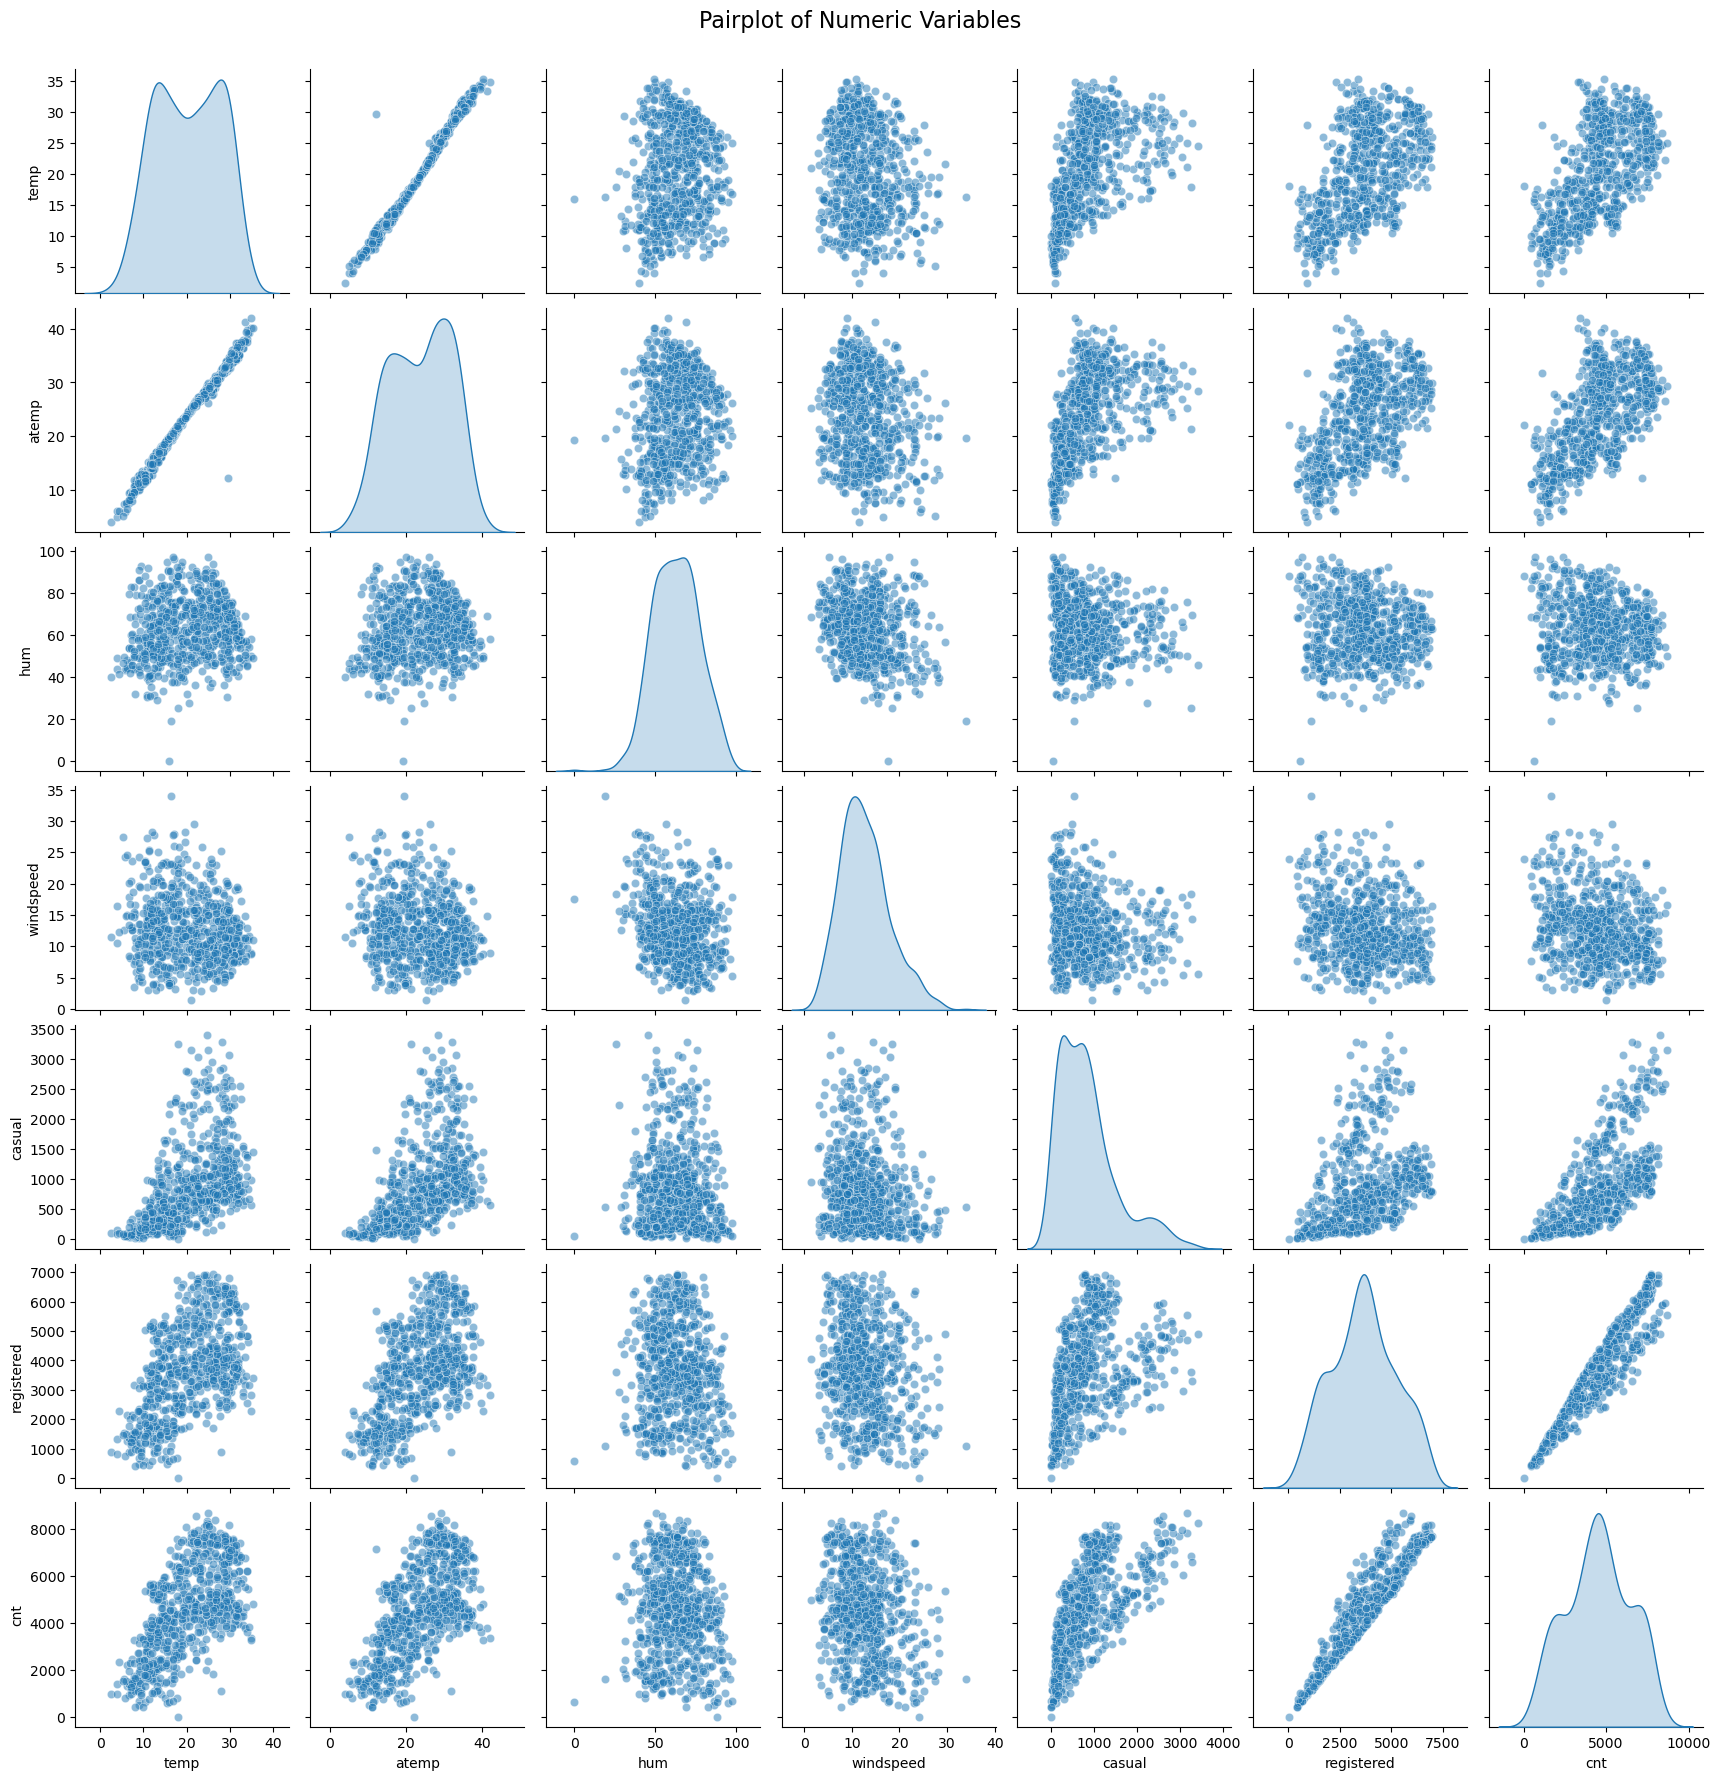

In [20]:
# Selecting only numeric columns for the pairplot

numeric_data = dayData[numeric_columns]

# Set a custom color palette for better aesthetics
custom_palette = sns.color_palette("viridis", as_cmap=True)

# Visualize Numeric Variables using Pairplot with increased data points
sns.pairplot(numeric_data, height=2.5, palette=custom_palette, markers='o', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Numeric Variables', y=1.02, size=16)
plt.show()

## Visualising Categorical Variables
As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

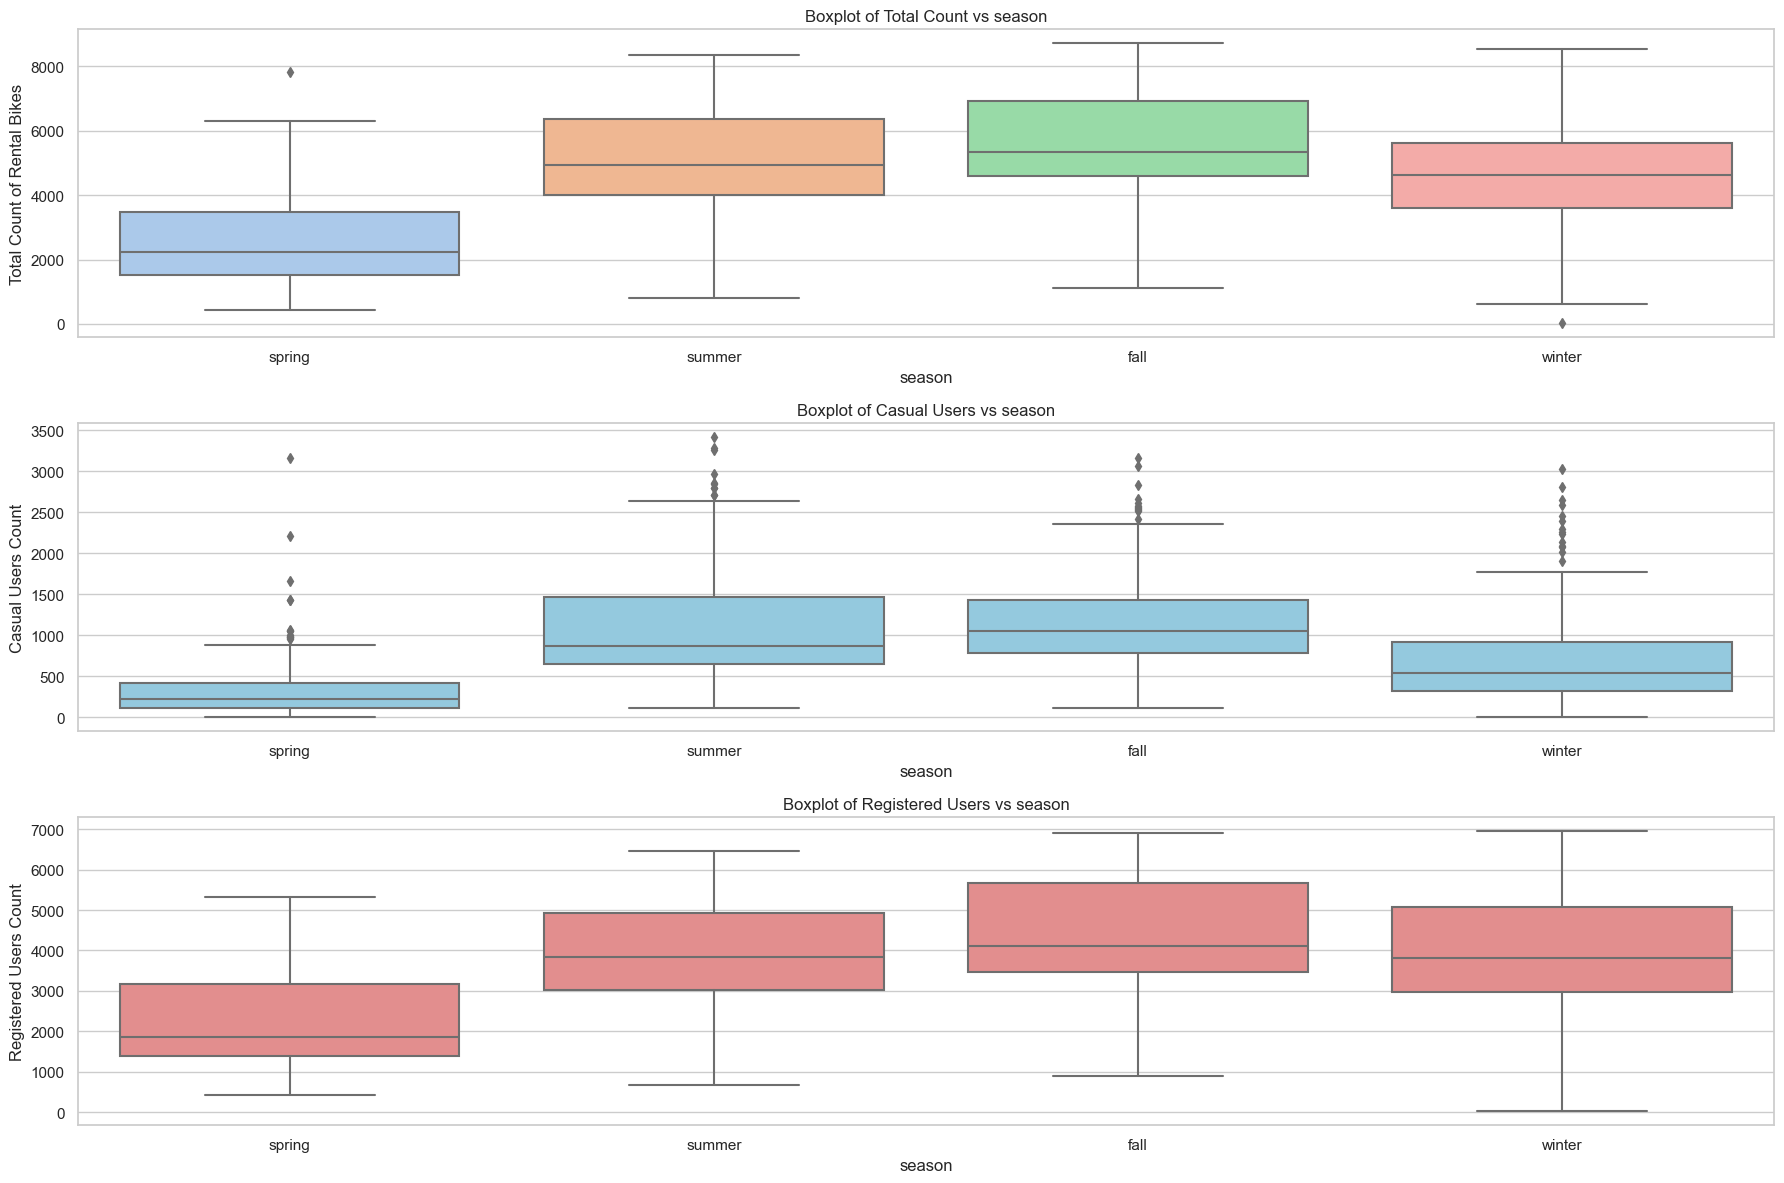

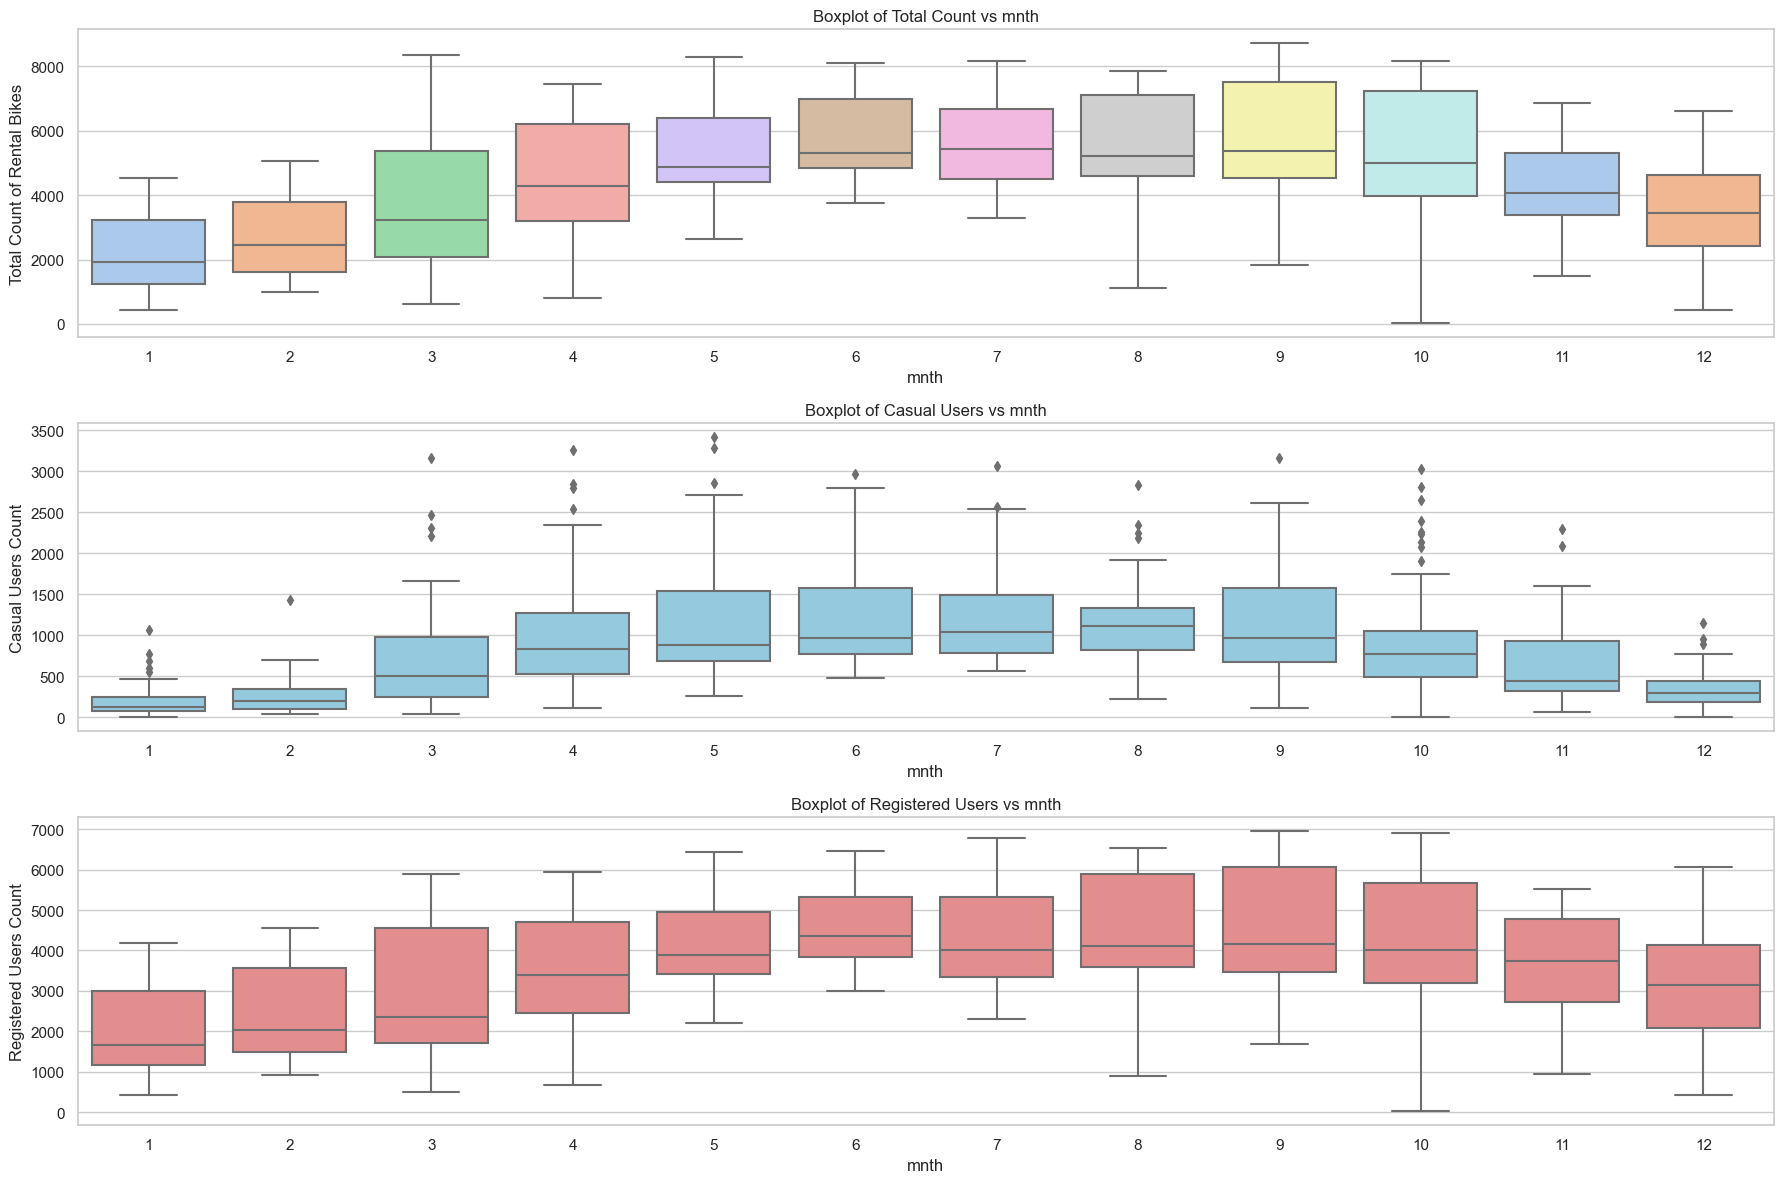

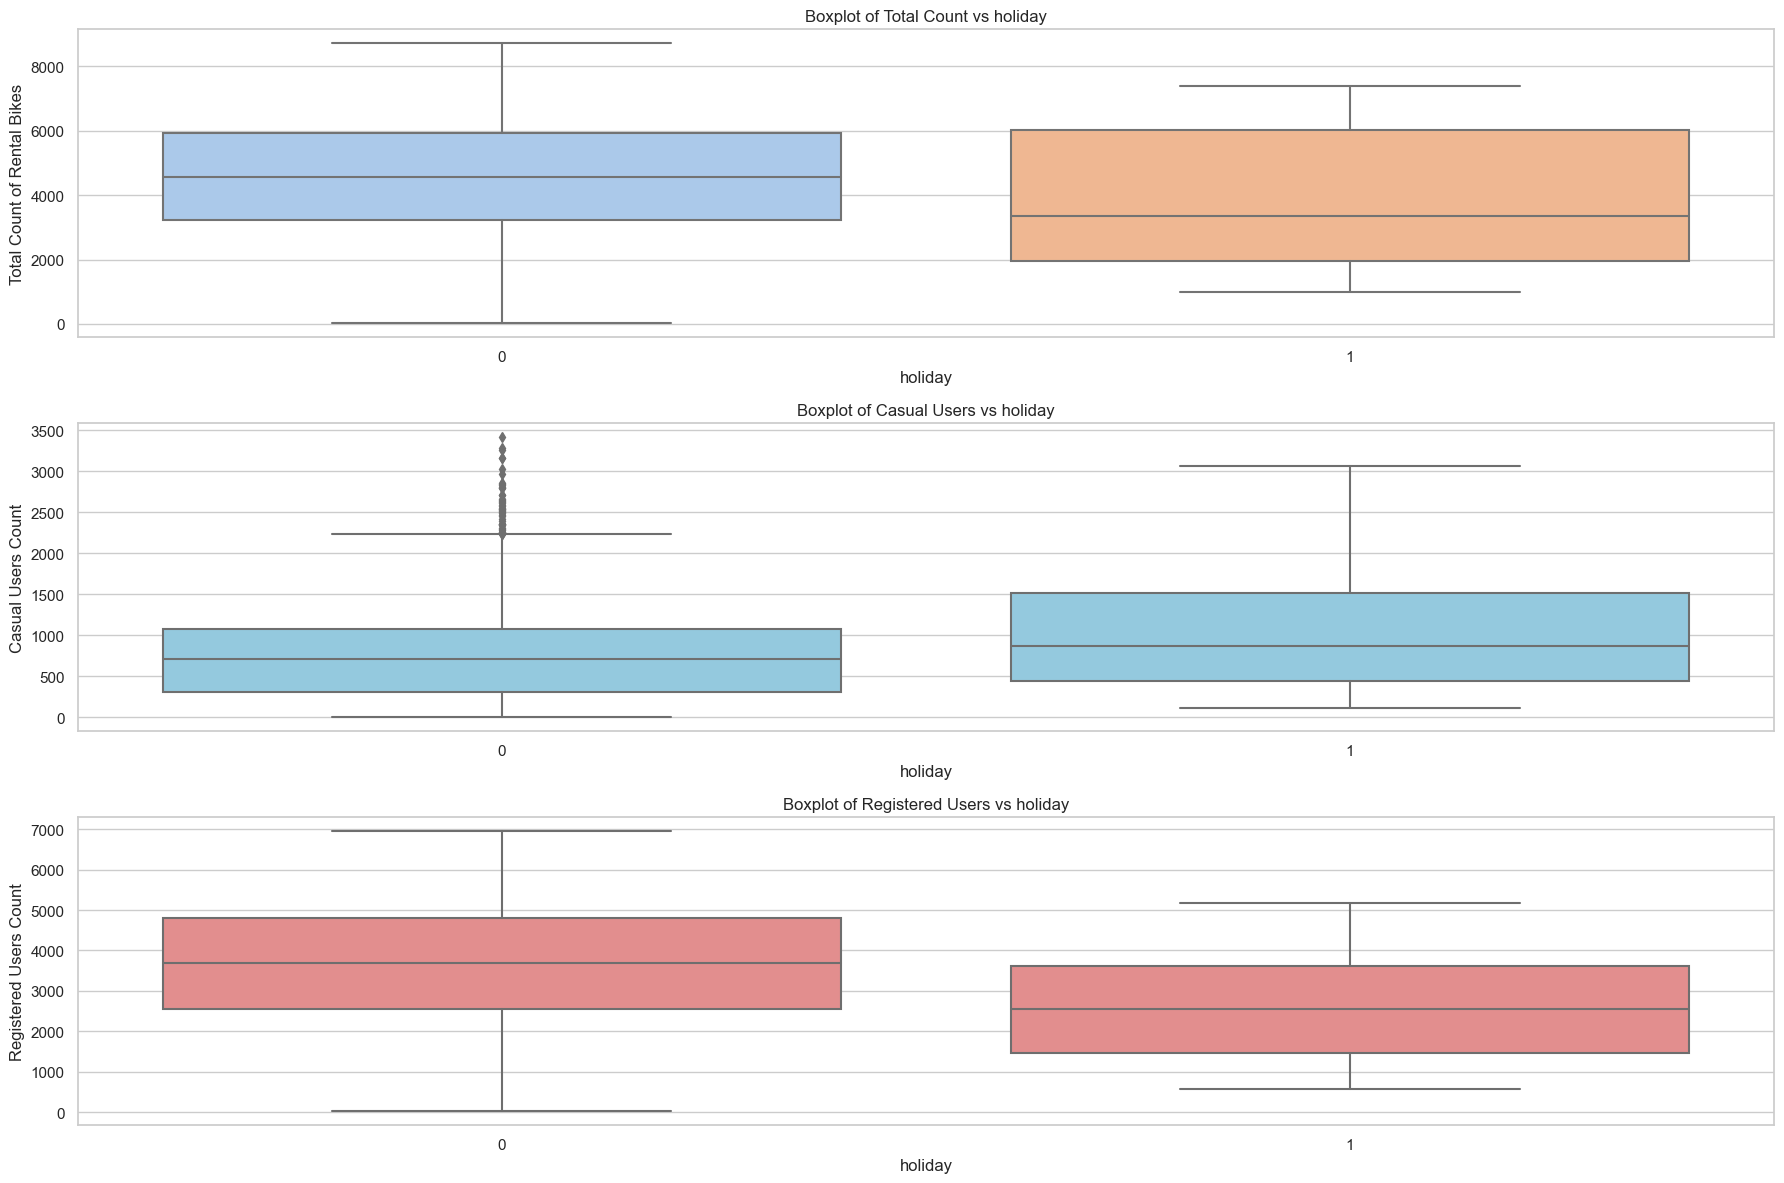

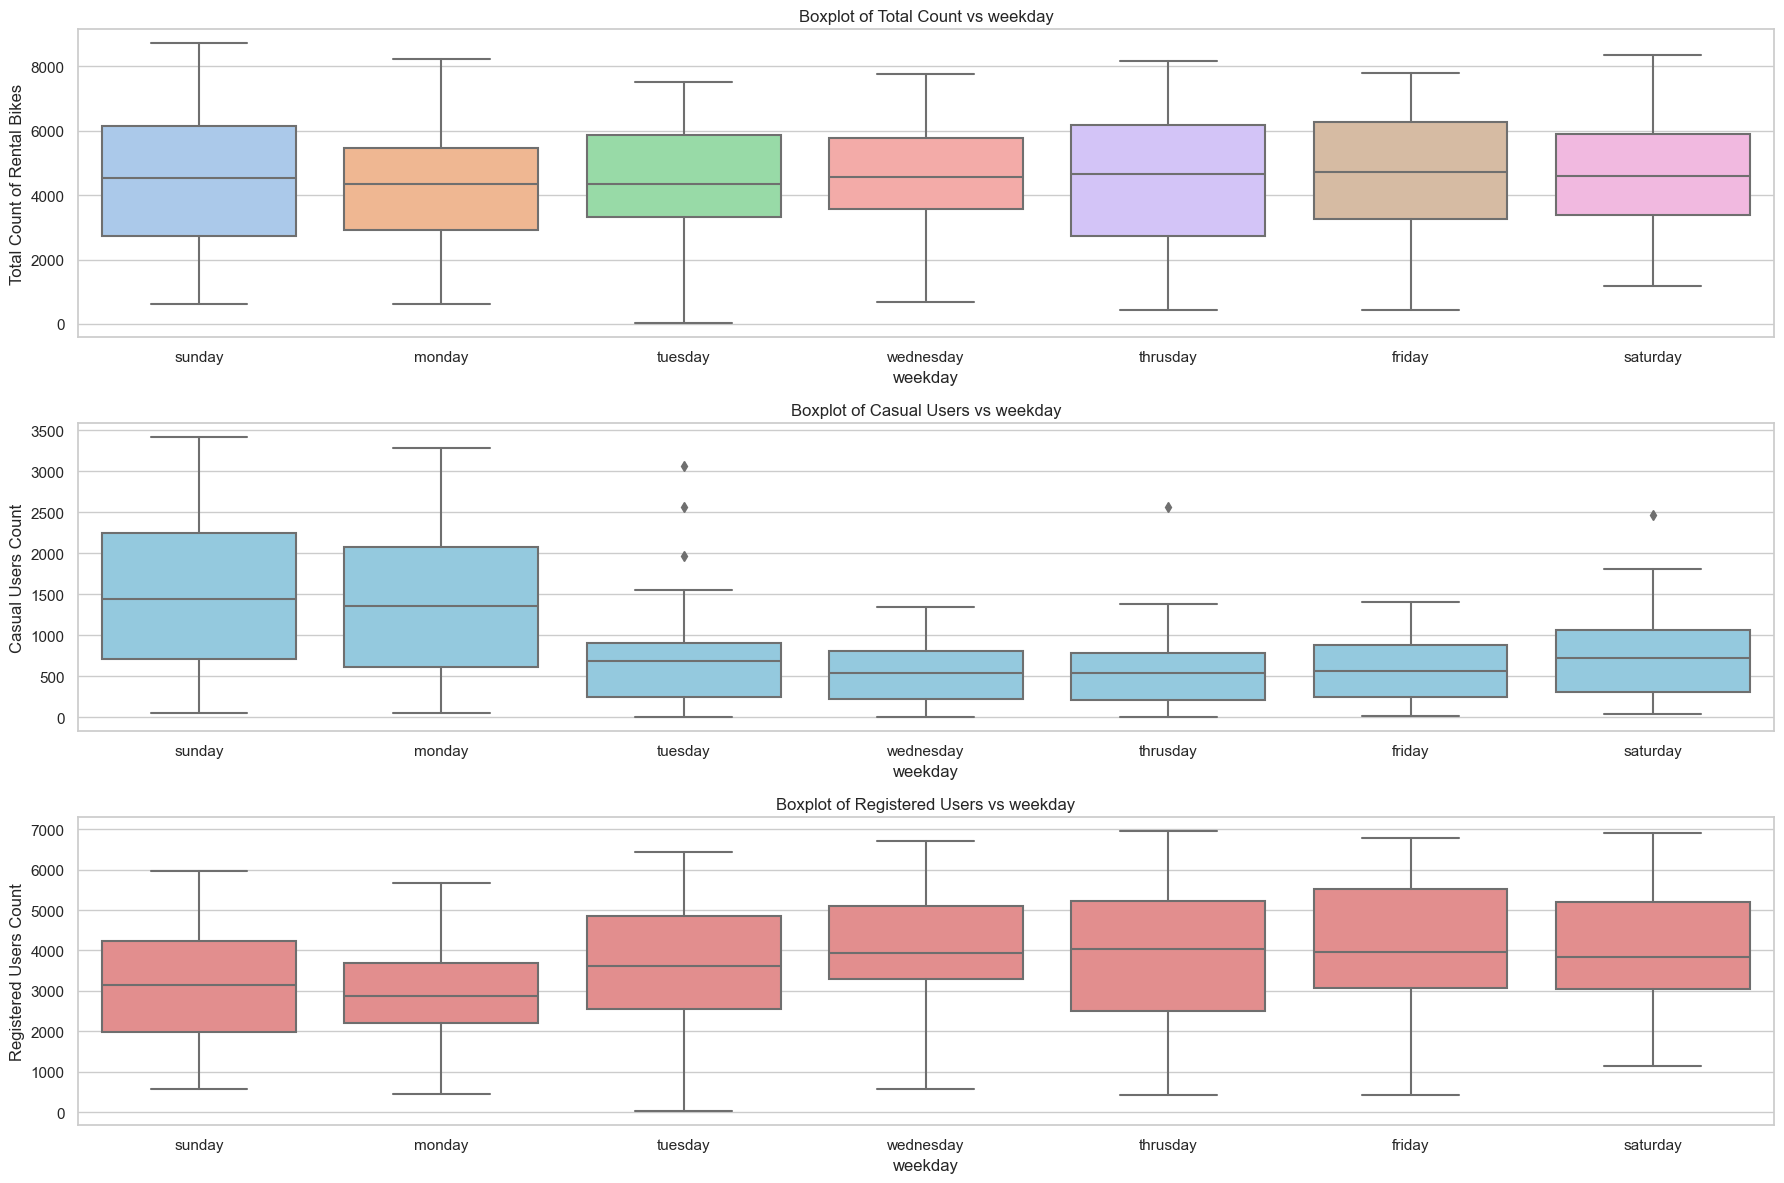

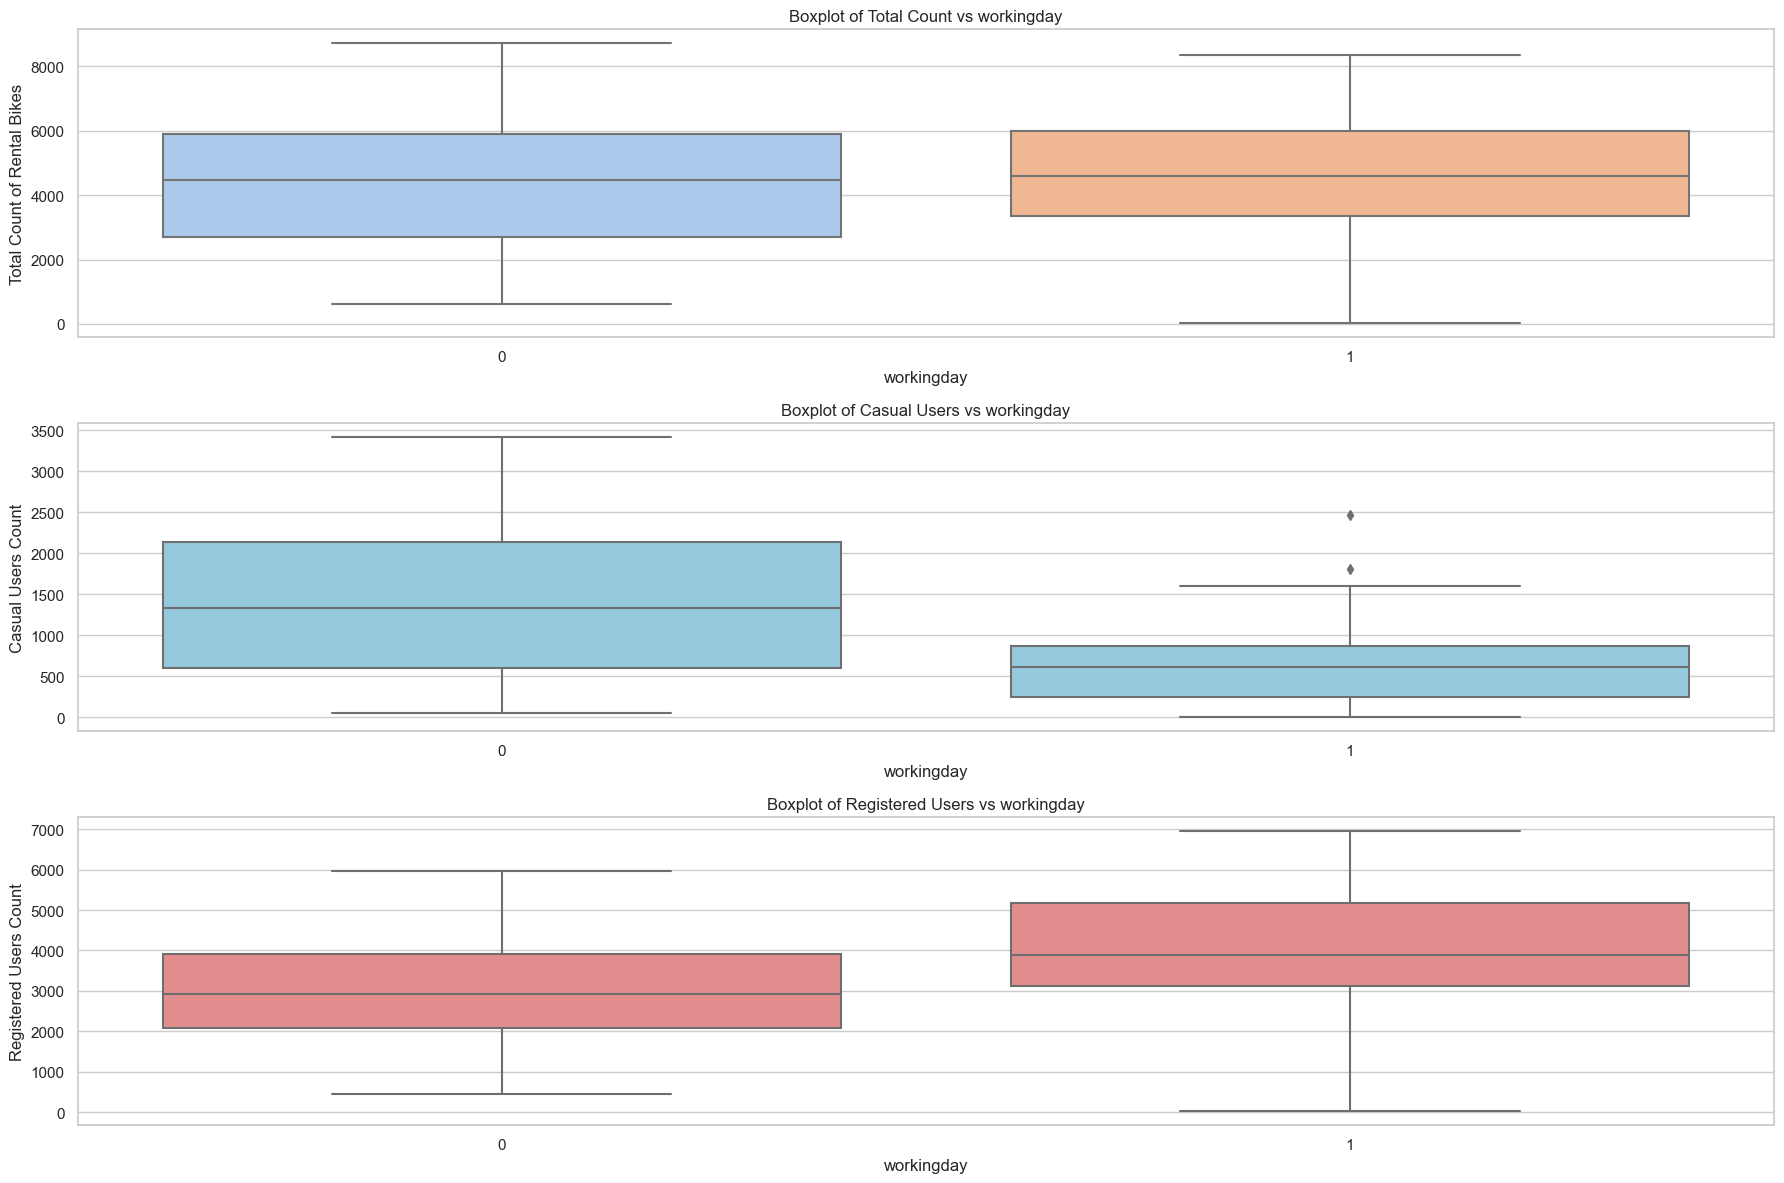

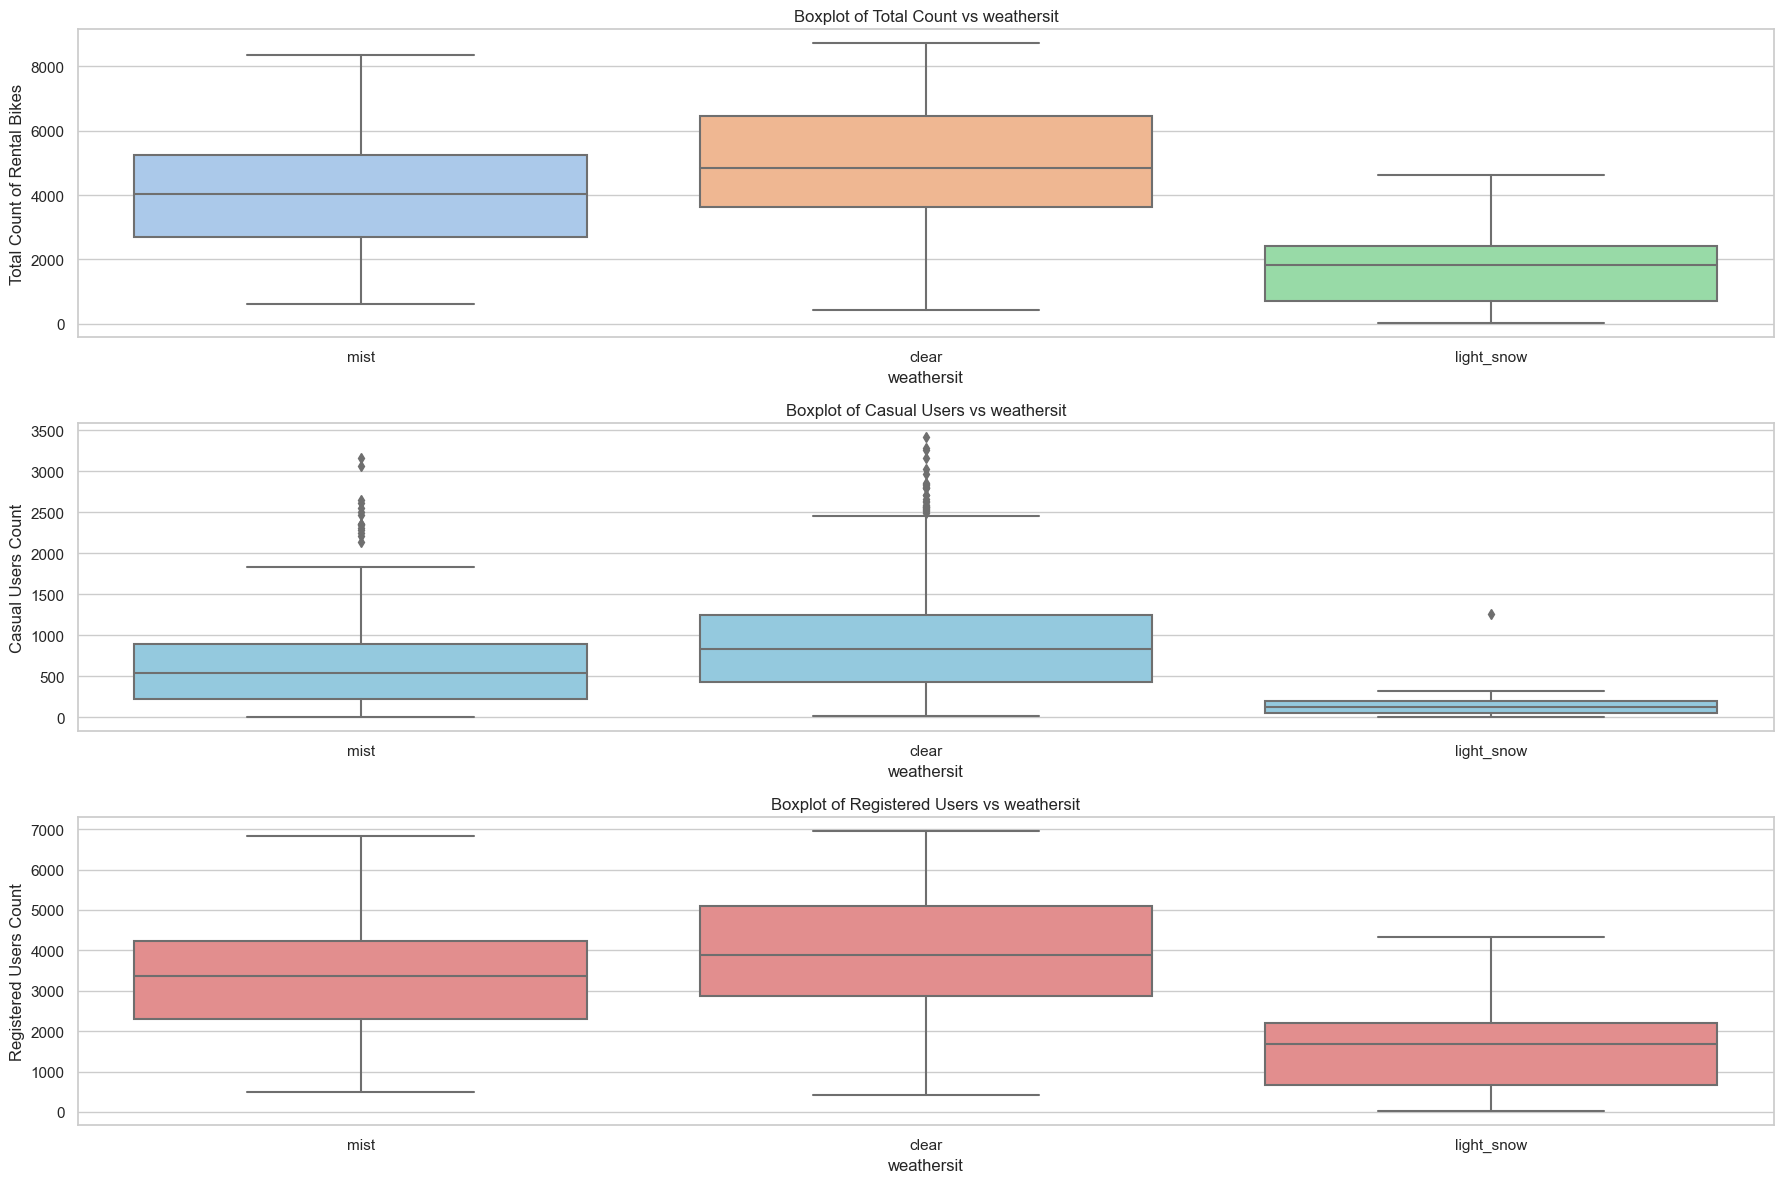

In [21]:
# Boxplots for categorical variables


for column in categorical_columns:
    plt.figure(figsize=(18, 12))
    sns.set(style="whitegrid")
    
    # Boxplot for Total Count
    plt.subplot(3, 1, 1)
    sns.boxplot(x=column, y='cnt', data=dayData, palette='pastel')
    plt.title(f'Boxplot of Total Count vs {column}')
    plt.xlabel(column)
    plt.ylabel('Total Count of Rental Bikes')

    # Boxplot for Casual Users
    plt.subplot(3, 1, 2)
    sns.boxplot(x=column, y='casual', data=dayData, color='skyblue')
    plt.title(f'Boxplot of Casual Users vs {column}')
    plt.xlabel(column)
    plt.ylabel('Casual Users Count')

    # Boxplot for Registered Users
    plt.subplot(3, 1, 3)
    sns.boxplot(x=column, y='registered', data=dayData, color='lightcoral')
    plt.title(f'Boxplot of Registered Users vs {column}')
    plt.xlabel(column)
    plt.ylabel('Registered Users Count')

    plt.tight_layout()
    plt.show()


## Creating the dummy variables from catogorical variables

In [22]:
status = pd.get_dummies(dayData['season'], dtype='int', drop_first=True)
status.head()

dayData = pd.concat([dayData, status], axis=1)
dayData = dayData.drop('season', axis=1)
dayData.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,0,1,0,sunday,0,mist,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,0,1,0,monday,0,mist,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,0,1,0,tuesday,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,0,1,0,wednesday,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,0,1,0,thrusday,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [23]:
status = pd.get_dummies(dayData['weathersit'], dtype='int', drop_first=True)
status.head()

dayData = pd.concat([dayData, status], axis=1)
dayData = dayData.drop('weathersit', axis=1)
dayData.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,light_snow,mist
0,0,1,0,sunday,0,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0,0,1
1,0,1,0,monday,0,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0,0,1
2,0,1,0,tuesday,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0,0,0
3,0,1,0,wednesday,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0,0,0
4,0,1,0,thrusday,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0,0,0


In [24]:
status = pd.get_dummies(dayData['weekday'], dtype='int', drop_first=True)
status.head()

dayData = pd.concat([dayData, status], axis=1)
dayData = dayData.drop('weekday', axis=1)
dayData.head()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,summer,winter,light_snow,mist,monday,saturday,sunday,thrusday,tuesday,wednesday
0,0,1,0,0,14.110847,18.18125,80.5833,10.749882,331,654,...,0,0,0,1,0,0,1,0,0,0
1,0,1,0,0,14.902598,17.68695,69.6087,16.652113,131,670,...,0,0,0,1,1,0,0,0,0,0
2,0,1,0,1,8.050924,9.47025,43.7273,16.636703,120,1229,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,1,8.200000,10.60610,59.0435,10.739832,108,1454,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,1,9.305237,11.46350,43.6957,12.522300,82,1518,...,0,0,0,0,0,0,0,1,0,0


## Creating test and train data sets

In [25]:
df_train, df_test = train_test_split(dayData, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 22)
(220, 22)


## Scaling the continues variables

In [26]:
# 1. instantiate an object
scaler = MinMaxScaler()

num_var = ['mnth', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
# 2. fit on data
df_train[num_var] = scaler.fit_transform(df_train[num_var])

df_train.head()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,summer,winter,light_snow,mist,monday,saturday,sunday,thrusday,tuesday,wednesday
576,1,0.545455,0,1,0.815169,0.766351,0.725633,0.264686,0.294422,0.899220,...,0,0,0,0,0,0,0,0,0,1
426,1,0.181818,0,0,0.442393,0.438975,0.640189,0.255342,0.290765,0.446145,...,0,0,0,1,0,0,1,0,0,0
728,1,1.000000,0,0,0.245101,0.200348,0.498067,0.663106,0.110332,0.203869,...,0,0,0,0,1,0,0,0,0,0
482,1,0.272727,0,0,0.395666,0.391735,0.504508,0.188475,0.340750,0.444701,...,1,0,0,1,0,0,1,0,0,0
111,0,0.272727,0,1,0.345824,0.318819,0.751824,0.380981,0.053337,0.214554,...,1,0,0,1,0,1,0,0,0,0


In [27]:
df_train.describe()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,summer,winter,light_snow,mist,monday,saturday,sunday,thrusday,tuesday,wednesday
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.503743,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.254689,0.523781,...,0.247059,0.247059,0.029412,0.345098,0.143137,0.127451,0.154902,0.158824,0.150980,0.131373
std,0.500429,0.315038,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.206015,0.227896,...,0.431725,0.431725,0.169124,0.475867,0.350557,0.333805,0.362166,0.365870,0.358381,0.338139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.181818,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.094179,0.353487,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.545455,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.212740,0.525123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.818182,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.327415,0.696073,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


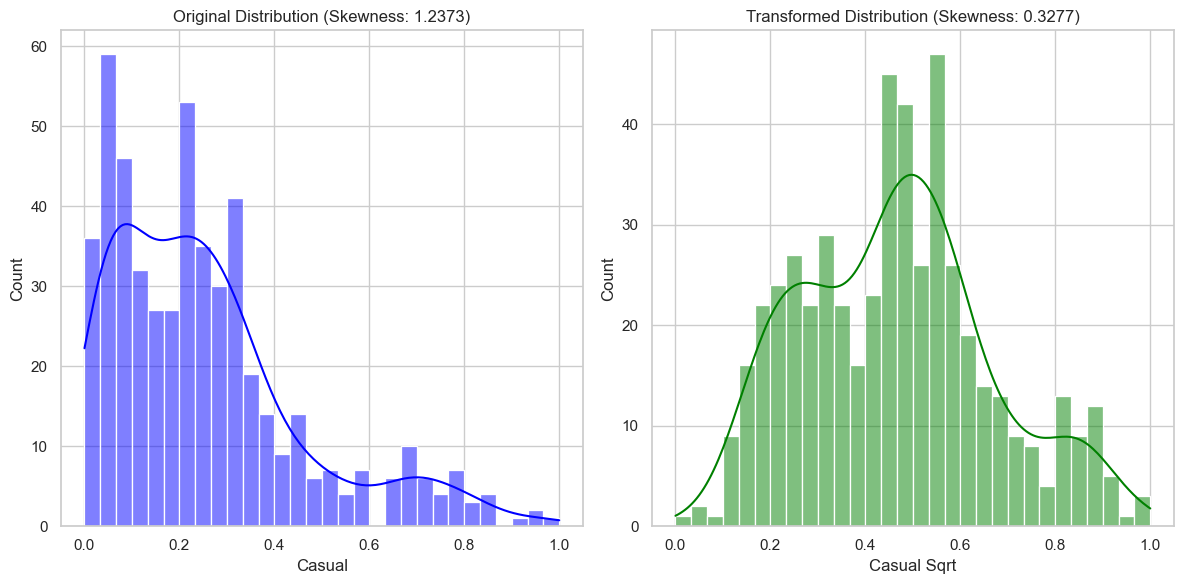

In [28]:
# Check the skewness of the 'casual' variable before transformation
before_skewness = df_train['casual'].skew()

# Apply square root transformation to address skewness
df_train['casual_sqrt'] = FunctionTransformer(np.sqrt).fit_transform(df_train[['casual']])

# Check the skewness of the transformed variable
after_skewness = df_train['casual_sqrt'].skew()

# Plot histograms for 'casual' before and after transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_train['casual'], bins=30, kde=True, color='blue')
plt.title(f'Original Distribution (Skewness: {before_skewness:.4f})')
plt.xlabel('Casual')

plt.subplot(1, 2, 2)
sns.histplot(df_train['casual_sqrt'], bins=30, kde=True, color='green')
plt.title(f'Transformed Distribution (Skewness: {after_skewness:.4f})')
plt.xlabel('Casual Sqrt')

plt.tight_layout()
plt.show()

In [29]:
df_train = df_train.drop('casual', axis=1)

In [30]:
df_train.head()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,registered,cnt,...,winter,light_snow,mist,monday,saturday,sunday,thrusday,tuesday,wednesday,casual_sqrt
576,1,0.545455,0,1,0.815169,0.766351,0.725633,0.264686,0.899220,0.827658,...,0,0,0,0,0,0,0,0,1,0.542607
426,1,0.181818,0,0,0.442393,0.438975,0.640189,0.255342,0.446145,0.465255,...,0,0,1,0,0,1,0,0,0,0.539226
728,1,1.000000,0,0,0.245101,0.200348,0.498067,0.663106,0.203869,0.204096,...,0,0,0,1,0,0,0,0,0,0.332163
482,1,0.272727,0,0,0.395666,0.391735,0.504508,0.188475,0.444701,0.482973,...,0,0,1,0,0,1,0,0,0,0.583738
111,0,0.272727,0,1,0.345824,0.318819,0.751824,0.380981,0.214554,0.191095,...,0,0,1,0,1,0,0,0,0,0.230949


## Creating HeatMap

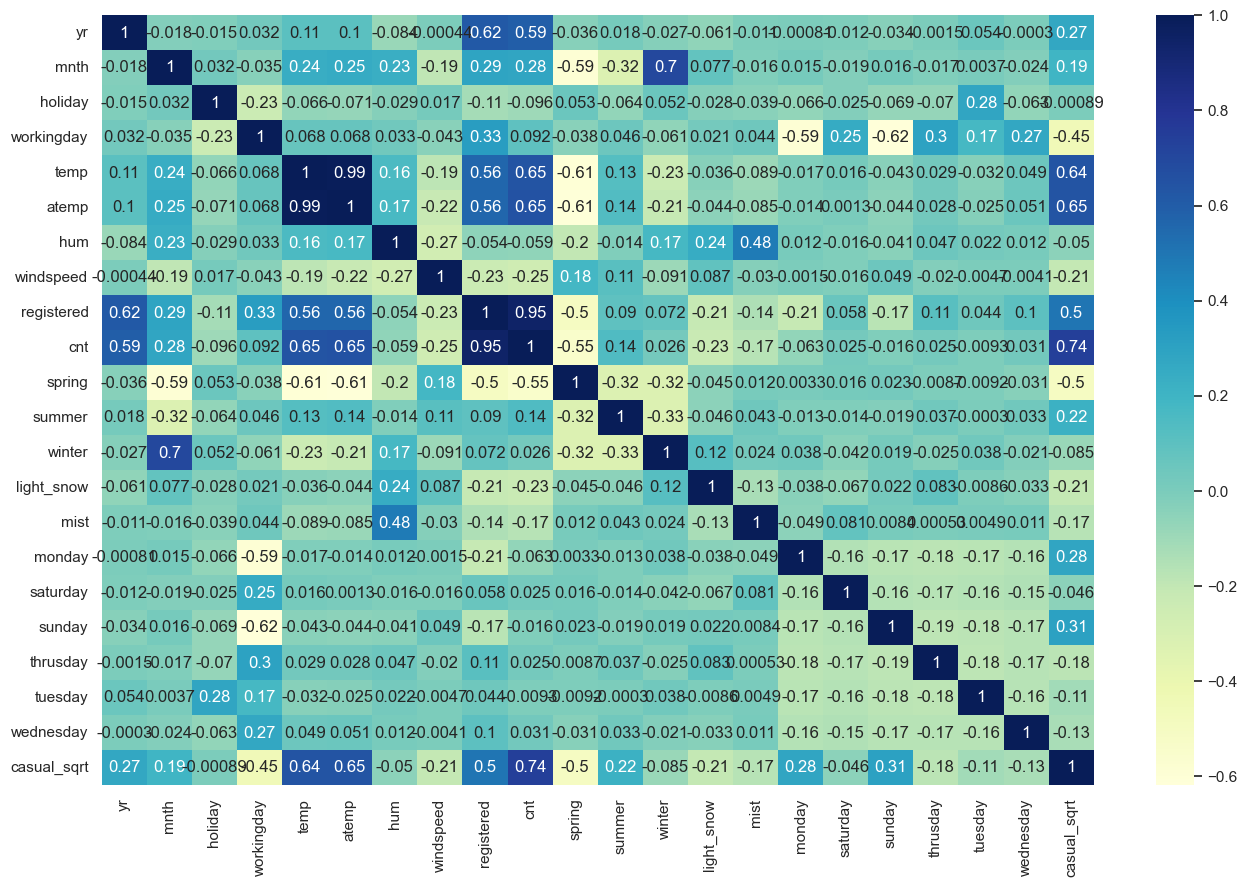

In [31]:
## Modeling
# heatMap
plt.figure(figsize=(16, 10))
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [32]:
df_train.columns

Index(['yr', 'mnth', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'registered', 'cnt', 'spring', 'summer', 'winter',
       'light_snow', 'mist', 'monday', 'saturday', 'sunday', 'thrusday',
       'tuesday', 'wednesday', 'casual_sqrt'],
      dtype='object')

- removing the below colums as they are highly corelated and may cause overfitting
    - temp
    - registered


In [33]:
# Variables like registered, casual_sqrt have high correlations with cnt -- either of the one must be included in model
# Variables like workingday provide very less information -- all three can be excluded
# Variables atem and temp seem to provide same information -- one must be dropped

cols_to_drop = ['workingday', 'atemp', 'registered']
df_train = df_train.drop(cols_to_drop, axis=1)

In [34]:
# X_train, y_train

y_train = df_train.pop('cnt')
X_train = df_train

## Building a linear model

Fit a regression line through the training data using `statsmodels`. We need to explicitly fit a constant using `sm.add_constant(X)` because if we don't perform this step, `statsmodels` fits a regression line passing through the origin, by default.

In [35]:
import statsmodels.api as sm

# Add a constant
X_train_lm = sm.add_constant(X_train[['temp']])

# Create a first fitted model
lr = sm.OLS(y_train, X_train_lm).fit()

In [36]:
# Check the parameters obtained

lr.params

const    0.169031
temp     0.640944
dtype: float64

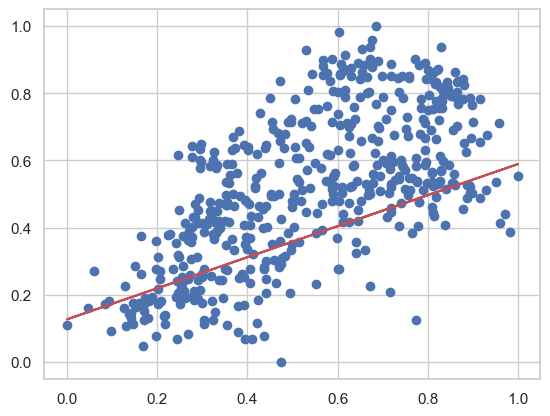

In [37]:
# Let's visualise the data with a scatter plot and the fitted regression line
plt.scatter(X_train_lm.iloc[:, 1], y_train)
plt.plot(X_train_lm.iloc[:, 1], 0.127 + 0.462*X_train_lm.iloc[:, 1], 'r')
plt.show()

In [38]:
# Print a summary of the linear regression model obtained
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     362.0
Date:                Wed, 10 Jan 2024   Prob (F-statistic):           2.46e-61
Time:                        22:26:19   Log-Likelihood:                 176.09
No. Observations:                 510   AIC:                            -348.2
Df Residuals:                     508   BIC:                            -339.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1690      0.020      8.608      0.0

### Adding another variable

In [39]:
# Assign all the feature variables to X
X_train_lm = X_train[['temp', 'casual_sqrt']]

In [40]:
X_train_lm = sm.add_constant(X_train_lm)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params

const          0.073816
temp           0.284065
casual_sqrt    0.620264
dtype: float64

In [41]:
# Check the summary
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     376.5
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          6.08e-101
Time:                        22:26:19   Log-Likelihood:                 271.02
No. Observations:                 510   AIC:                            -536.0
Df Residuals:                     507   BIC:                            -523.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0738      0.017      4.221      

In [42]:
# Assign all the feature variables to X
X_train_lm = X_train[['temp', 'casual_sqrt', 'yr']]

In [43]:
X_train_lm = sm.add_constant(X_train_lm)

lr = sm.OLS(y_train, X_train_lm).fit()

lr.params

const          0.024232
temp           0.334434
casual_sqrt    0.449551
yr             0.199880
dtype: float64

In [44]:
# Print the summary of the model

print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     598.6
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          5.59e-166
Time:                        22:26:19   Log-Likelihood:                 425.20
No. Observations:                 510   AIC:                            -842.4
Df Residuals:                     506   BIC:                            -825.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0242      0.013      1.841      

### Adding all the variables to the model

In [45]:
# Check all the columns of the dataframe

dayData.columns

Index(['yr', 'mnth', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'spring', 'summer',
       'winter', 'light_snow', 'mist', 'monday', 'saturday', 'sunday',
       'thrusday', 'tuesday', 'wednesday'],
      dtype='object')

In [46]:
X_train_lm = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lm).fit()

lr_1.params

const          0.139648
yr             0.168391
mnth           0.013664
holiday       -0.177252
temp           0.080306
hum           -0.029771
windspeed     -0.059629
spring        -0.046790
summer        -0.019543
winter         0.049539
light_snow    -0.117675
mist          -0.027701
monday        -0.213517
saturday      -0.026217
sunday        -0.177626
thrusday       0.016049
tuesday       -0.018899
wednesday      0.000284
casual_sqrt    0.777949
dtype: float64

In [47]:
lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     333.8
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          8.11e-262
Time:                        22:26:19   Log-Likelihood:                 697.56
No. Observations:                 510   AIC:                            -1357.
Df Residuals:                     491   BIC:                            -1277.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1396      0.027      5.226      0.000       0.087       0.192
yr              0.1684      0.006     26.957      0.000       0.156       0.181
mnth            0.0137      0.017      0.783      0.434      -0.021       0.048
holiday        -0.1773      0.019     -9.358      0.000      -0.214      -0.140
temp            0.0803      0.029      2.799      0.005       0.024       0.137
hum            -0.0298      0.027     -1.118      0.264      -0.082       0.023
windspeed      -0.0596      0.019     -3.203      0.001      -0.096      -0.023
spring         -0.0468      0.016     -3.010      0.003      -0.077      -0.016
summer         -0.0195      0.011     -1.812      0.071      -0.041       0.002
winter          0.0495      0.013      3.954      0.000       0.025       0.074
light_snow     -0.1177      0.019     -6.109      0.000      -0.156      -0.080
mist           -0.0277      0.007     -3.713      0.000      -0.042      -0.013
monday         -0.2135      0.013    -16.902      0.000      -0.238      -0.189
saturday       -0.0262      0.011     -2.371      0.018      -0.048      -0.004
sunday         -0.1776      0.013    -13.751      0.000      -0.203      -0.152
thrusday        0.0160      0.010      1.545      0.123      -0.004       0.036
tuesday        -0.0189      0.011     -1.770      0.077      -0.040       0.002
wednesday       0.0003      0.011      0.026      0.979      -0.021       0.022
casual_sqrt     0.7779      0.032     24.277      0.000       0.715       0.841
==============================================================================
Omnibus:                      100.978   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.946
Skew:                          -0.915   Prob(JB):                     9.10e-70
Kurtosis:                       6.408   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [49]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,temp,33.19
17,casual_sqrt,32.12
4,hum,31.13
1,mnth,12.43
5,windspeed,5.05
8,winter,4.71
6,spring,4.43
13,sunday,3.34
7,summer,3.10
11,monday,2.95


### With below algorithm
We could have:
- High p-value, high VIF
- High-low:
    - High p, low VIF: remove these first
    - low p, high VIF: second choice
- Low p, low VIF

In [50]:
# Dropping highly correlated variables and insignificant variables

X = X_train.drop('mnth', axis=1)

In [51]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()

In [52]:
# Print the summary of the model
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     353.7
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          5.76e-263
Time:                        22:26:19   Log-Likelihood:                 697.25
No. Observations:                 510   AIC:                            -1358.
Df Residuals:                     492   BIC:                            -1282.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1465      0.025      5.799      0.000       0.097       0.196
yr              0.1682      0.006     26.957      0.000       0.156       0.180
holiday        -0.1766      0.019     -9.337      0.000      -0.214      -0.139
temp            0.0810      0.029      2.827      0.005       0.025       0.137
hum            -0.0278      0.027     -1.050      0.294      -0.080       0.024
windspeed      -0.0593      0.019     -3.187      0.002      -0.096      -0.023
spring         -0.0523      0.014     -3.772      0.000      -0.080      -0.025
summer         -0.0233      0.010     -2.402      0.017      -0.042      -0.004
winter          0.0535      0.011      4.676      0.000       0.031       0.076
light_snow     -0.1185      0.019     -6.164      0.000      -0.156      -0.081
mist           -0.0280      0.007     -3.758      0.000      -0.043      -0.013
monday         -0.2139      0.013    -16.945      0.000      -0.239      -0.189
saturday       -0.0265      0.011     -2.394      0.017      -0.048      -0.005
sunday         -0.1777      0.013    -13.764      0.000      -0.203      -0.152
thrusday        0.0158      0.010      1.524      0.128      -0.005       0.036
tuesday        -0.0194      0.011     -1.820      0.069      -0.040       0.002
wednesday      -0.0002      0.011     -0.021      0.984      -0.022       0.021
casual_sqrt     0.7781      0.032     24.290      0.000       0.715       0.841
==============================================================================
Omnibus:                       98.855   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.090
Skew:                          -0.900   Prob(JB):                     2.07e-67
Kurtosis:                       6.348   Cond. No.                         25.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,32.55
16,casual_sqrt,31.89
3,hum,28.25
4,windspeed,4.91
5,spring,3.93
7,winter,3.38
12,sunday,3.34
10,monday,2.95
6,summer,2.71
0,yr,2.56


In [54]:
# Dropping highly correlated variables and insignificant variables

X = X.drop('hum', axis=1)

In [55]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()

In [56]:
# Print the summary of the model
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     375.6
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          5.07e-264
Time:                        22:26:19   Log-Likelihood:                 696.67
No. Observations:                 510   AIC:                            -1359.
Df Residuals:                     493   BIC:                            -1287.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1319      0.021      6.244      0.000       0.090       0.173
yr              0.1685      0.006     27.017      0.000       0.156       0.181
holiday        -0.1773      0.019     -9.379      0.000      -0.214      -0.140
temp            0.0726      0.028      2.638      0.009       0.019       0.127
windspeed      -0.0530      0.018     -3.008      0.003      -0.088      -0.018
spring         -0.0536      0.014     -3.885      0.000      -0.081      -0.027
summer         -0.0246      0.010     -2.565      0.011      -0.043      -0.006
winter          0.0509      0.011      4.556      0.000       0.029       0.073
light_snow     -0.1252      0.018     -6.897      0.000      -0.161      -0.090
mist           -0.0322      0.006     -5.154      0.000      -0.045      -0.020
monday         -0.2156      0.013    -17.228      0.000      -0.240      -0.191
saturday       -0.0265      0.011     -2.396      0.017      -0.048      -0.005
sunday         -0.1788      0.013    -13.890      0.000      -0.204      -0.154
thrusday        0.0156      0.010      1.503      0.133      -0.005       0.036
tuesday        -0.0199      0.011     -1.867      0.063      -0.041       0.001
wednesday      -0.0004      0.011     -0.039      0.969      -0.022       0.021
casual_sqrt     0.7832      0.032     24.738      0.000       0.721       0.845
==============================================================================
Omnibus:                       98.178   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.690
Skew:                          -0.893   Prob(JB):                     4.17e-67
Kurtosis:                       6.346   Cond. No.                         22.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
15,casual_sqrt,31.87
2,temp,21.97
3,windspeed,4.83
11,sunday,3.29
9,monday,2.87
0,yr,2.55
4,spring,2.44
5,summer,2.31
6,winter,2.12
12,thrusday,2.09


In [58]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('wednesday', axis=1)

In [59]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)
lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
lr_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     401.5
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          2.49e-265
Time:                        22:26:19   Log-Likelihood:                 696.67
No. Observations:                 510   AIC:                            -1361.
Df Residuals:                     494   BIC:                            -1294.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1317      0.021      6.413      0.000       0.091       0.172
yr              0.1685      0.006     27.046      0.000       0.156       0.181
holiday        -0.1773      0.019     -9.394      0.000      -0.214      -0.140
temp            0.0725      0.027      2.642      0.008       0.019       0.126
windspeed      -0.0530      0.018     -3.011      0.003      -0.088      -0.018
spring         -0.0536      0.014     -3.890      0.000      -0.081      -0.027
summer         -0.0246      0.010     -2.573      0.010      -0.043      -0.006
winter          0.0509      0.011      4.562      0.000       0.029       0.073
light_snow     -0.1251      0.018     -6.911      0.000      -0.161      -0.090
mist           -0.0322      0.006     -5.162      0.000      -0.045      -0.020
monday         -0.2154      0.011    -18.876      0.000      -0.238      -0.193
saturday       -0.0263      0.010     -2.720      0.007      -0.045      -0.007
sunday         -0.1786      0.012    -15.105      0.000      -0.202      -0.155
thrusday        0.0158      0.009      1.787      0.075      -0.002       0.033
tuesday        -0.0197      0.009     -2.129      0.034      -0.038      -0.002
casual_sqrt     0.7832      0.032     24.787      0.000       0.721       0.845
==============================================================================
Omnibus:                       98.149   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.510
Skew:                          -0.893   Prob(JB):                     4.56e-67
Kurtosis:                       6.345   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
14,casual_sqrt,31.87
2,temp,20.76
3,windspeed,4.81
11,sunday,2.81
0,yr,2.55
9,monday,2.42
5,summer,2.24
4,spring,2.20
6,winter,1.97
8,mist,1.67


In [61]:

# Dropping highly correlated variables and insignificant variables

X = X.drop('thrusday', axis=1)

In [62]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     428.0
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          5.78e-266
Time:                        22:26:19   Log-Likelihood:                 695.03
No. Observations:                 510   AIC:                            -1360.
Df Residuals:                     495   BIC:                            -1297.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1370      0.020      6.728      0.000       0.097       0.177
yr              0.1686      0.006     27.016      0.000       0.156       0.181
holiday        -0.1780      0.019     -9.411      0.000      -0.215      -0.141
temp            0.0741      0.027      2.696      0.007       0.020       0.128
windspeed      -0.0539      0.018     -3.055      0.002      -0.089      -0.019
spring         -0.0530      0.014     -3.836      0.000      -0.080      -0.026
summer         -0.0239      0.010     -2.494      0.013      -0.043      -0.005
winter          0.0513      0.011      4.589      0.000       0.029       0.073
light_snow     -0.1235      0.018     -6.813      0.000      -0.159      -0.088
mist           -0.0321      0.006     -5.125      0.000      -0.044      -0.020
monday         -0.2209      0.011    -20.064      0.000      -0.243      -0.199
saturday       -0.0320      0.009     -3.513      0.000      -0.050      -0.014
sunday         -0.1841      0.011    -16.094      0.000      -0.207      -0.162
tuesday        -0.0254      0.009     -2.931      0.004      -0.042      -0.008
casual_sqrt     0.7817      0.032     24.692      0.000       0.719       0.844
==============================================================================
Omnibus:                      101.402   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.311
Skew:                          -0.901   Prob(JB):                     9.36e-74
Kurtosis:                       6.546   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
13,casual_sqrt,31.87
2,temp,20.26
3,windspeed,4.81
11,sunday,2.61
0,yr,2.55
9,monday,2.24
5,summer,2.20
4,spring,2.08
6,winter,1.91
8,mist,1.67


In [64]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('casual_sqrt', axis=1)


In [65]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
lr_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     185.9
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          4.25e-181
Time:                        22:26:19   Log-Likelihood:                 490.32
No. Observations:                 510   AIC:                            -952.6
Df Residuals:                     496   BIC:                            -893.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2278      0.030      7.620      0.000       0.169       0.287
yr             0.2349      0.008     27.934      0.000       0.218       0.251
holiday       -0.0843      0.028     -3.050      0.002      -0.139      -0.030
temp           0.4663      0.033     13.924      0.000       0.400       0.532
windspeed     -0.1557      0.026     -6.081      0.000      -0.206      -0.105
spring        -0.0815      0.021     -3.967      0.000      -0.122      -0.041
summer         0.0395      0.014      2.868      0.004       0.012       0.067
winter         0.0778      0.017      4.682      0.000       0.045       0.110
light_snow    -0.2830      0.025    -11.200      0.000      -0.333      -0.233
mist          -0.0777      0.009     -8.708      0.000      -0.095      -0.060
monday        -0.0496      0.013     -3.887      0.000      -0.075      -0.025
saturday       0.0111      0.013      0.833      0.405      -0.015       0.037
sunday         0.0104      0.012      0.840      0.401      -0.014       0.035
tuesday       -0.0137      0.013     -1.062      0.289      -0.039       0.012
==============================================================================
Omnibus:                       71.268   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              179.242
Skew:                          -0.713   Prob(JB):                     1.20e-39
Kurtosis:                       5.530   Cond. No.                         17.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
3,windspeed,4.63
2,temp,3.94
0,yr,2.08
4,spring,2.06
5,summer,1.82
6,winter,1.70
8,mist,1.55
12,tuesday,1.44
11,sunday,1.35
9,monday,1.33


In [67]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('saturday', axis=1)

In [68]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     201.5
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          4.14e-182
Time:                        22:26:19   Log-Likelihood:                 489.97
No. Observations:                 510   AIC:                            -953.9
Df Residuals:                     497   BIC:                            -898.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2307      0.030      7.770      0.000       0.172       0.289
yr             0.2349      0.008     27.936      0.000       0.218       0.251
holiday       -0.0840      0.028     -3.040      0.002      -0.138      -0.030
temp           0.4659      0.033     13.918      0.000       0.400       0.532
windspeed     -0.1556      0.026     -6.079      0.000      -0.206      -0.105
spring        -0.0817      0.021     -3.980      0.000      -0.122      -0.041
summer         0.0391      0.014      2.840      0.005       0.012       0.066
winter         0.0774      0.017      4.662      0.000       0.045       0.110
light_snow    -0.2844      0.025    -11.284      0.000      -0.334      -0.235
mist          -0.0772      0.009     -8.673      0.000      -0.095      -0.060
monday        -0.0521      0.012     -4.211      0.000      -0.076      -0.028
sunday         0.0078      0.012      0.654      0.514      -0.016       0.031
tuesday       -0.0163      0.013     -1.302      0.193      -0.041       0.008
==============================================================================
Omnibus:                       70.323   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.049
Skew:                          -0.702   Prob(JB):                     2.17e-39
Kurtosis:                       5.532   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,windspeed,4.62
2,temp,3.75
0,yr,2.08
4,spring,2.02
5,summer,1.81
6,winter,1.68
8,mist,1.54
11,tuesday,1.36
10,sunday,1.28
9,monday,1.26


In [70]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('sunday', axis=1)

In [71]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          3.37e-183
Time:                        22:26:19   Log-Likelihood:                 489.75
No. Observations:                 510   AIC:                            -955.5
Df Residuals:                     498   BIC:                            -904.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2326      0.030      7.879      0.000       0.175       0.291
yr             0.2348      0.008     27.945      0.000       0.218       0.251
holiday       -0.0846      0.028     -3.063      0.002      -0.139      -0.030
temp           0.4653      0.033     13.913      0.000       0.400       0.531
windspeed     -0.1548      0.026     -6.059      0.000      -0.205      -0.105
spring        -0.0819      0.021     -3.989      0.000      -0.122      -0.042
summer         0.0390      0.014      2.831      0.005       0.012       0.066
winter         0.0775      0.017      4.671      0.000       0.045       0.110
light_snow    -0.2844      0.025    -11.290      0.000      -0.334      -0.235
mist          -0.0772      0.009     -8.682      0.000      -0.095      -0.060
monday        -0.0539      0.012     -4.459      0.000      -0.078      -0.030
tuesday       -0.0180      0.012     -1.467      0.143      -0.042       0.006
==============================================================================
Omnibus:                       67.974   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.520
Skew:                          -0.672   Prob(JB):                     7.70e-39
Kurtosis:                       5.540   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,windspeed,4.60
2,temp,3.66
0,yr,2.08
4,spring,1.99
5,summer,1.81
6,winter,1.65
8,mist,1.53
10,tuesday,1.31
9,monday,1.21
1,holiday,1.13


In [73]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('tuesday', axis=1)


In [74]:
# Build a third fitted model
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()
# Print the summary of the model
lr_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     241.2
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          6.16e-184
Time:                        22:26:19   Log-Likelihood:                 488.65
No. Observations:                 510   AIC:                            -955.3
Df Residuals:                     499   BIC:                            -908.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2291      0.029      7.776      0.000       0.171       0.287
yr             0.2340      0.008     27.876      0.000       0.217       0.250
holiday       -0.0956      0.027     -3.593      0.000      -0.148      -0.043
temp           0.4669      0.033     13.952      0.000       0.401       0.533
windspeed     -0.1544      0.026     -6.036      0.000      -0.205      -0.104
spring        -0.0811      0.021     -3.950      0.000      -0.121      -0.041
summer         0.0389      0.014      2.820      0.005       0.012       0.066
winter         0.0774      0.017      4.661      0.000       0.045       0.110
light_snow    -0.2842      0.025    -11.268      0.000      -0.334      -0.235
mist          -0.0773      0.009     -8.676      0.000      -0.095      -0.060
monday        -0.0510      0.012     -4.273      0.000      -0.074      -0.028
==============================================================================
Omnibus:                       65.805   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.485
Skew:                          -0.648   Prob(JB):                     5.79e-38
Kurtosis:                       5.527   Cond. No.                         17.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,windspeed,4.60
2,temp,3.62
0,yr,2.07
4,spring,1.98
5,summer,1.80
6,winter,1.64
8,mist,1.53
9,monday,1.18
7,light_snow,1.08
1,holiday,1.04


### LM->3
### Using RFE 

In [76]:
# Assuming X_train and y_train are your feature and target matrices, respectively
lm_3 = LinearRegression()

# Specify the number of features to select (e.g., 15)
num_features_to_select = 10

# Create RFE model and select features
rfe = RFE(lm_3, n_features_to_select=num_features_to_select, step=1)
X_train_rfe = rfe.fit_transform(X_train, y_train)

In [77]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('mnth', False, 8),
 ('holiday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 2),
 ('summer', False, 6),
 ('winter', True, 1),
 ('light_snow', True, 1),
 ('mist', False, 3),
 ('monday', True, 1),
 ('saturday', False, 4),
 ('sunday', True, 1),
 ('thrusday', False, 7),
 ('tuesday', False, 5),
 ('wednesday', False, 9),
 ('casual_sqrt', True, 1)]

In [78]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'winter', 'light_snow',
       'monday', 'sunday', 'casual_sqrt'],
      dtype='object')

In [79]:
X_train.columns[~rfe.support_]

Index(['mnth', 'spring', 'summer', 'mist', 'saturday', 'thrusday', 'tuesday',
       'wednesday'],
      dtype='object')

# Building model using statsmodel, for the detailed statistics

In [80]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [81]:
# Adding a constant variable  
X_train_rfe = sm.add_constant(X_train_rfe)

In [82]:
lm_3 = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [83]:
#Let's see the summary of our linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     551.2
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          2.49e-262
Time:                        22:26:19   Log-Likelihood:                 673.55
No. Observations:                 510   AIC:                            -1325.
Df Residuals:                     499   BIC:                            -1279.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1070      0.019      5.539      

In [84]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_rfe)

In [85]:
lm_3 = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model

In [86]:
#Let's see the summary of our linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     551.2
Date:                Wed, 10 Jan 2024   Prob (F-statistic):          2.49e-262
Time:                        22:26:19   Log-Likelihood:                 673.55
No. Observations:                 510   AIC:                            -1325.
Df Residuals:                     499   BIC:                            -1279.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1070      0.019      5.539      

In [87]:
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'temp', 'hum', 'windspeed', 'winter',
       'light_snow', 'monday', 'sunday', 'casual_sqrt'],
      dtype='object')

In [88]:
# Calculate the VIFs for the new model

vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,44.65
10,casual_sqrt,4.26
3,temp,3.04
9,sunday,1.78
8,monday,1.61
4,hum,1.31
5,windspeed,1.20
1,yr,1.19
7,light_snow,1.18
6,winter,1.16


In [89]:
X_train_new = X_train_rfe.drop(['const'], axis=1)

# Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [90]:
y_train_cnt = lm_3.predict(X_train_lm)

Text(0.5, 0, 'Errors')

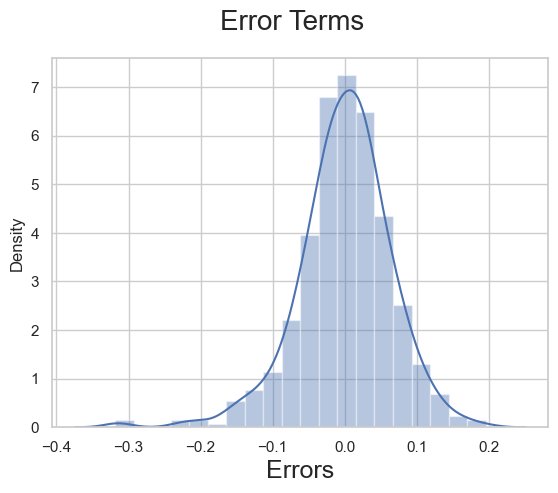

In [91]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

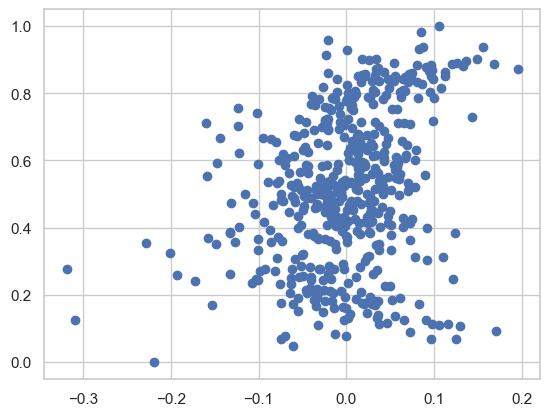

In [92]:
plt.scatter(y_train - y_train_cnt, y_train); # No definite pattern found which fails to void our assumption

# Making Predictions


### Applying the scaling on the test sets

In [93]:
num_vars = ['mnth', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

df_test[num_vars] = scaler.transform(df_test[num_vars])

In [94]:
# Check the skewness of the 'casual' variable
print(df_test['casual'].skew())

# Apply square root transformation to address skewness
from sklearn.preprocessing import FunctionTransformer
df_test['casual_sqrt'] = FunctionTransformer(np.sqrt).fit_transform(df_test[['casual']])
df_test = df_test.drop(columns=['casual'], axis=1)

# Check the skewness of the transformed variable
print(df_test['casual_sqrt'].skew())

1.3228380743239396
0.3947837458315335


In [95]:
df_test.head()

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,registered,cnt,...,winter,light_snow,mist,monday,saturday,sunday,thrusday,tuesday,wednesday,casual_sqrt
184,0,0.545455,1,0,0.831783,0.769660,0.657364,0.084219,0.427086,0.692706,...,0,0,1,0,0,0,0,1,0,0.966207
535,1,0.454545,0,1,0.901354,0.842587,0.610133,0.153728,0.767976,0.712034,...,0,0,0,0,0,0,1,0,0,0.514940
299,0,0.818182,0,1,0.511964,0.496145,0.837699,0.334206,0.346376,0.303382,...,1,0,1,0,0,0,0,0,0,0.269330
221,0,0.636364,0,1,0.881625,0.795343,0.437098,0.339570,0.559630,0.547400,...,0,0,0,0,0,0,1,0,0,0.518479
152,0,0.454545,0,1,0.817246,0.741471,0.314298,0.537414,0.608143,0.569029,...,0,0,0,0,0,0,0,0,0,0.472982


In [96]:
# X_train, y_train

y_test = df_test.pop('cnt')
X_test = df_test

In [97]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [98]:
# Making predictions
y_pred = lm_3.predict(X_test_new)

# Model Evaluation

Text(0, 0.5, 'y_pred')

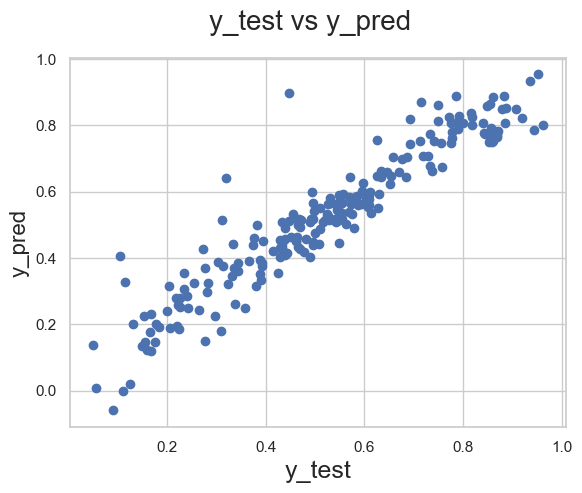

In [99]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

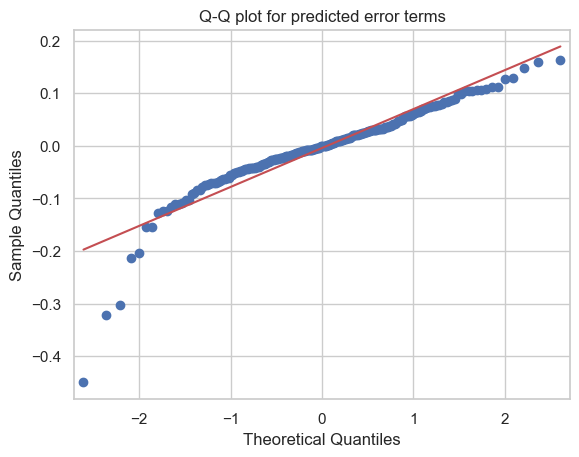

In [100]:
residuals = y_test - y_pred

sm.qqplot(residuals, line='s')
plt.title('Q-Q plot for predicted error terms')
plt.grid(True)
plt.show()

In [101]:
# evaluate
r2_score(y_true = y_test, y_pred = y_pred)

0.8851199859976614

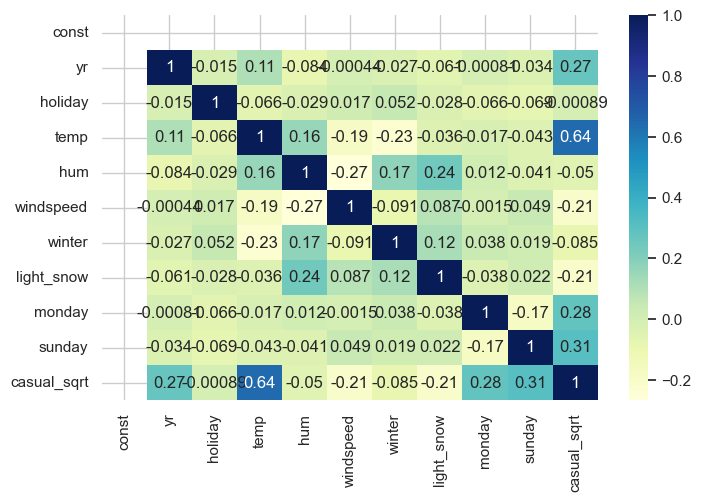

In [102]:
plt.figure(figsize=(8,5))
sns.heatmap(X_train_rfe.corr(), cmap="YlGnBu", annot=True)
plt.show();

What we got between temp and casual_sqrt is not coliniality but it's actually casuality.

This is the final model and this are the short listed veriables.